# STEP 4: Count the number of observations in each ecosystem, during

each month of 2023

Much of the data in GBIF is **crowd-sourced**. As a result, we need not
just the number of observations in each ecosystem each month – we need
to **normalize** by some measure of **sampling effort**. After all, we
wouldn’t expect the same number of observations in the Arctic as we
would in a National Park, even if there were the same number of Veeries.
In this case, we’re normalizing using the average number of observations
for each ecosystem and each month. This should help control for the
number of active observers in each location and time of year.

### Set up your analysis

First things first – let’s load your stored variables.

In [10]:
%store -r

### Identify the ecoregion for each observation

You can combine the ecoregions and the observations **spatially** using
a method called `.sjoin()`, which stands for spatial join.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-read"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Read More</div></div><div class="callout-body-container callout-body"><p>Check out the <a
href="https://geopandas.org/en/stable/docs/user_guide/mergingdata.html#spatial-joins"><code>geopandas</code>
documentation on spatial joins</a> to help you figure this one out. You
can also ask your favorite LLM (Large-Language Model, like ChatGPT)</p></div></div>

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Perform a spatial join</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Identify the correct values for the <code>how=</code> and
<code>predicate=</code> parameters of the spatial join.</li>
<li>Select only the columns you will need for your plot.</li>
<li>Run the code.</li>
</ol></div></div>

In [11]:
gbif_ecoregion_gdf = (
    eco_gdf
    # Match the CRS of the GBIF data and the ecoregions
    .to_crs(gbif_gdf.crs)
    # Find ecoregion for each observation
    .sjoin(
        gbif_gdf,
        how='inner', 
        predicate='contains')
)
gbif_ecoregion_gdf

,name,area,geometry,gbifID,month
ecoregion_id,,,,,
13.0,Alberta-British Columbia foothills forests,17.133639,"MULTIPOLYGON (((-119.53979 55.81661, -119.5443...",4743927038,5
13.0,Alberta-British Columbia foothills forests,17.133639,"MULTIPOLYGON (((-119.53979 55.81661, -119.5443...",4621947377,5
13.0,Alberta-British Columbia foothills forests,17.133639,"MULTIPOLYGON (((-119.53979 55.81661, -119.5443...",4761090115,6
13.0,Alberta-British Columbia foothills forests,17.133639,"MULTIPOLYGON (((-119.53979 55.81661, -119.5443...",4765238615,7
13.0,Alberta-British Columbia foothills forests,17.133639,"MULTIPOLYGON (((-119.53979 55.81661, -119.5443...",4630693711,6
...,...,...,...,...,...
845.0,North Atlantic moist mixed forests,5.586107,"MULTIPOLYGON (((-9.09602 52.60926, -9.07859 52...",4633848077,10
845.0,North Atlantic moist mixed forests,5.586107,"MULTIPOLYGON (((-9.09602 52.60926, -9.07859 52...",4749131402,9
845.0,North Atlantic moist mixed forests,5.586107,"MULTIPOLYGON (((-9.09602 52.60926, -9.07859 52...",4763942306,9


### Count the observations in each ecoregion each month

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Group observations by ecoregion</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Replace <code>columns_to_group_by</code> with a list of columns.
Keep in mind that you will end up with one row for each group – you want
to count the observations in each ecoregion by month.</li>
<li>Select only month/ecosystem combinations that have more than one
occurrence recorded, since a single occurrence could be an error.</li>
<li>Use the <code>.groupby()</code> and <code>.mean()</code> methods to
compute the mean occurrences by ecoregion and by month.</li>
<li>Run the code – it will normalize the number of occurrences by month
and ecoretion.</li>
</ol></div></div>

In [12]:
occurrence_df = (
    gbif_ecoregion_gdf
    # Reset index
    .reset_index()
    # For each ecoregion, for each month...
    .groupby(['ecoregion_id', 'month'])
    # ...count the number of occurrences
    .agg(
        occurrences=('gbifID', 'count'),
        area=('area', 'first'))
)

# Normalize by area
occurrence_df['density'] = (
    occurrence_df.occurrences 
    / occurrence_df.area
)

# Get rid of rare observations (possible misidentification?)
occurrence_df = occurrence_df[occurrence_df.occurrences>1]

,occurrences,area,density
month,,,
1,7.666667,71.521667,0.108516
2,7.333333,75.264253,0.087302
3,5.666667,35.252754,0.204116
4,140.472222,11.290958,17.490862
5,1207.169492,20.336924,92.500595
6,1041.571429,25.544896,63.707132
7,572.894737,26.210646,34.124410
8,164.972973,25.862437,11.518052
9,260.897436,19.746055,27.421185


In [13]:
# Take the mean by ecoregion
mean_occurrences_by_ecoregion = (
    occurrence_df
    .groupby('ecoregion_id')
    .mean()
)
mean_occurrences_by_ecoregion

,occurrences,area,density
ecoregion_id,,,
13.0,2.000000,17.133639,0.116729
17.0,1425.333333,7.958751,179.090084
23.0,3.000000,3.346216,0.896535
33.0,930.857143,16.637804,55.948319
34.0,243.142857,18.674884,13.019779
...,...,...,...
810.0,6.000000,5.968650,1.005253
833.0,9.000000,0.610793,14.734931
838.0,104.500000,4.286144,24.380889


In [14]:
# Take the mean by month
mean_occurrences_by_month = (
    occurrence_df
    .groupby('month')
    .mean()
)
mean_occurrences_by_month

,occurrences,area,density
month,,,
1,7.666667,71.521667,0.108516
2,7.333333,75.264253,0.087302
3,5.666667,35.252754,0.204116
4,140.472222,11.290958,17.490862
5,1207.169492,20.336924,92.500595
6,1041.571429,25.544896,63.707132
7,572.894737,26.210646,34.124410
8,164.972973,25.862437,11.518052
9,260.897436,19.746055,27.421185


### Normalize the observations

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Normalize</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Divide occurrences by the mean occurrences by month AND the mean
occurrences by ecoregion</li>
</ol></div></div>

In [21]:
# Normalize by space and time for sampling effort
occurrence_df['norm_occurrences'] = (
    occurrence_df[['density']]
    / mean_occurrences_by_ecoregion[['density']]
    / mean_occurrences_by_month[['density']]
)
occurrence_df

occurrences       area     density  norm_occurrences
ecoregion_id month                                                      
13.0         5                2  17.133639    0.116729          0.010811
             6                2  17.133639    0.116729          0.015697
             7                2  17.133639    0.116729          0.029305
17.0         4                2   7.958751    0.251296          0.000080
             5             2980   7.958751  374.430624          0.022602
...                         ...        ...         ...               ...
839.0        7              293  35.905513    8.160307          0.036475
             8               40  35.905513    1.114035          0.014753
             9               11  35.905513    0.306360          0.001704
845.0        9               25   5.586107    4.475389          0.056981
             10               7   5.586107    1.253109          0.071383

[308 rows x 4 columns]

<Axes: xlabel='month', ylabel='norm_occurrences'>

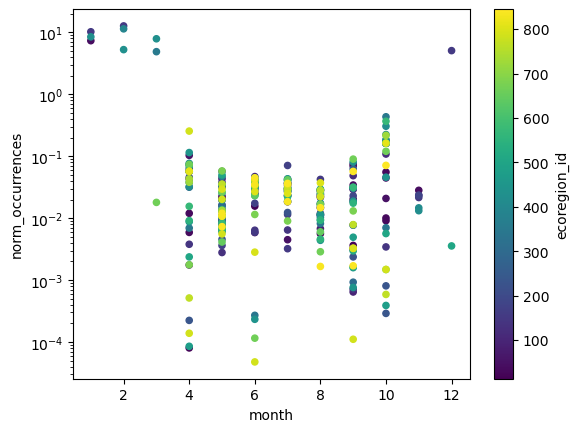

In [23]:
occurrence_df.reset_index().plot.scatter(
    x='month', y='norm_occurrences', c='ecoregion_id',
    logy=True
)

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Make sure to store the new version of your <code>DataFrame</code> for
other notebooks!</p>
<div id="2e01613b" class="cell" data-execution_count="9">
<div class="sourceCode" id="cb1"><pre
class="sourceCode python cell-code"><code class="sourceCode python"><span id="cb1-1"><a href="#cb1-1" aria-hidden="true" tabindex="-1"></a><span class="op">%</span>store occurrence_df</span></code></pre></div>
</div></div></div>

In [24]:
%store occurrence_df

Stored 'occurrence_df' (DataFrame)


: 